In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aryarishabh/hand-gesture-recognition-dataset

In [ ]:
!unzip /content/hand-gesture-recognition-dataset.zip

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
print(device)

cuda


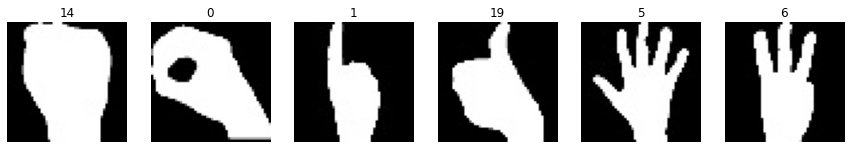

In [7]:
w = 10
h = 10
fig = plt.figure(figsize=(15,10))
columns = 6
rows = 1
train = "/content/train/train"

for i in range(0, columns*rows ):
  folderName = os.path.join((train), os.listdir(train)[i])
  img = cv2.imread(folderName+'/'+(os.listdir(os.path.join((train), os.listdir(train)[i]))[i]))
  fig.add_subplot(rows, columns, i+1)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title(os.path.basename(folderName))

plt.show()

In [8]:
transformer=transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
    ])

In [9]:
train_data = torchvision.datasets.ImageFolder("/content/train/train",
                                  transform=transformer)
test_data = torchvision.datasets.ImageFolder("/content/test/test",
                                  transform=transformer)


In [10]:
batch_size = 32
train_iterator = DataLoader(train_data,
                                 batch_size=batch_size
                                 ,shuffle=True)
test_iterator = DataLoader(test_data,
                                 batch_size=batch_size
                                 ,shuffle=True)

In [ ]:
!pip install wandb
!wandb login

In [ ]:
import wandb

wandb.init(project="Hand gestures", entity="manar")

In [34]:
class model(nn.Module):
  def __init__(self):
    super().__init__()

    self.CNNLayer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(4,2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(4,2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(4,2),
      )
      
    self.fc1 = nn.Linear(64*2*2, 1024)
    self.out = nn.Linear(1024, 20)

  def forward(self, x):
    x = self.CNNLayer(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    out = self.out(x)
    return out

In [35]:
model=model().to(device)

In [36]:
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_function=nn.CrossEntropyLoss()

In [37]:
train_count = len(train_data)
test_count = len(test_data)

In [38]:
print(train_count,test_count)

18000 6000


In [39]:
num_epochs = 10

wandb.watch(model, loss_function, log="all", log_freq=10)

for epoch in tqdm(range(num_epochs)):

    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for _, (images,labels) in enumerate(train_iterator):

        images, labels = images.to(device), labels.to(device)   

        optimizer.zero_grad()
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
                    
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))


    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    wandb.log({"epoch": epoch, "loss": train_loss, "accuracy": train_accuracy})

    model.eval()
    
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(test_iterator):
      images, labels = images.to(device), labels.to(device)
      outputs=model(images)
      loss_t=loss_function(outputs,labels)

      test_loss+= loss_t.cpu().data*images.size(0)
      _,prediction=torch.max(outputs.data,1)
      test_accuracy+=int(torch.sum(prediction==labels.data))

    test_accuracy=test_accuracy/test_count
    test_loss=test_loss/test_count

    wandb.log({"test_accuracy": test_accuracy, "test_loss":test_loss})

    print(f'Epoch: {epoch+1}\n    Train loss = {train_loss:.5f} , Train accuracy = {train_accuracy:.5f} , Test accuracy: {test_accuracy:.5f} , Test loss = {test_loss:.5f}')
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
    Train loss = 0.06790 , Train accuracy = 0.98622 , Test accuracy: 0.99983 , Test loss = 0.00105
Epoch: 2
    Train loss = 0.00384 , Train accuracy = 0.99900 , Test accuracy: 1.00000 , Test loss = 0.00022
Epoch: 3
    Train loss = 0.00016 , Train accuracy = 0.99994 , Test accuracy: 1.00000 , Test loss = 0.00014
Epoch: 4
    Train loss = 0.00002 , Train accuracy = 1.00000 , Test accuracy: 1.00000 , Test loss = 0.00014
Epoch: 5
    Train loss = 0.00001 , Train accuracy = 1.00000 , Test accuracy: 1.00000 , Test loss = 0.00013
Epoch: 6
    Train loss = 0.00001 , Train accuracy = 1.00000 , Test accuracy: 1.00000 , Test loss = 0.00013
Epoch: 7
    Train loss = 0.00000 , Train accuracy = 1.00000 , Test accuracy: 1.00000 , Test loss = 0.00013
Epoch: 8
    Train loss = 0.00000 , Train accuracy = 1.00000 , Test accuracy: 1.00000 , Test loss = 0.00013
Epoch: 9
    Train loss = 0.00000 , Train accuracy = 1.00000 , Test accuracy: 1.00000 , Test loss = 0.00012
Epoch: 10
    Train loss = 0